In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import os

In [2]:
os.chdir('/home/pavit21178/BTP/fourth meeting')
df=pd.read_csv('merged_data_modified.csv')
y=df['id']
x=df['seq']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

100%|██████████| 353/353 [00:00<00:00, 205780.31it/s]


100%|██████████| 89/89 [00:00<00:00, 36850.25it/s]


One_hot


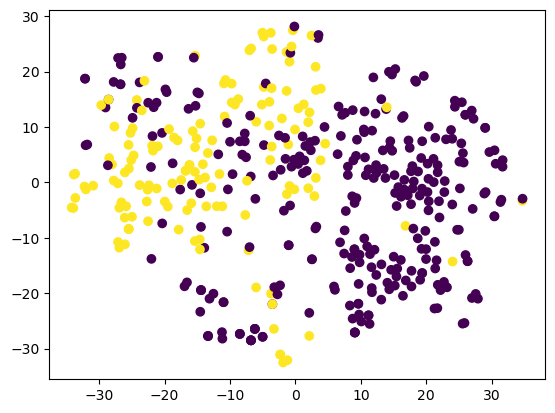

100%|██████████| 89/89 [00:00<00:00, 49014.32it/s]


One_hot_6_bit


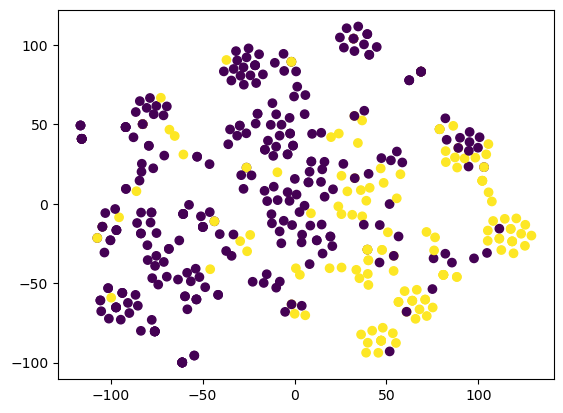

100%|██████████| 89/89 [00:00<00:00, 51024.20it/s]


Binary_5_bit


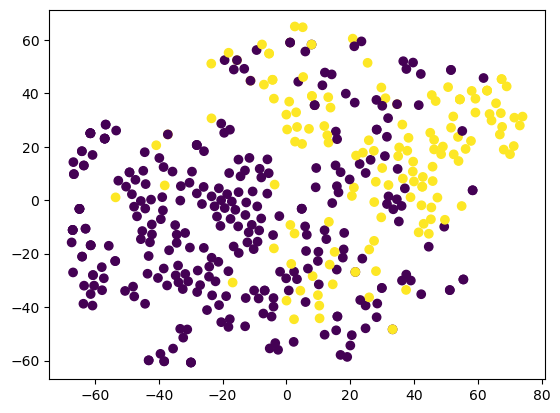

100%|██████████| 89/89 [00:00<00:00, 41966.62it/s]


Hydrophobicity_matrix


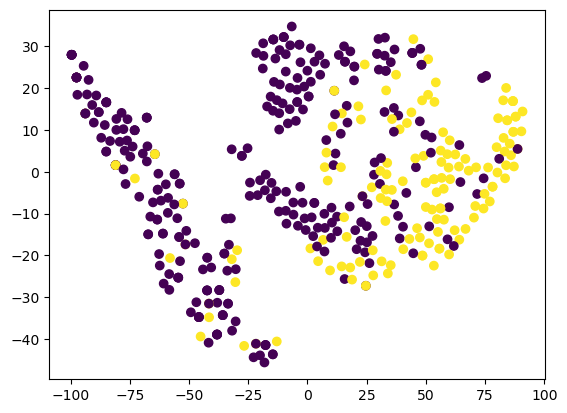

100%|██████████| 89/89 [00:00<00:00, 52311.25it/s]


Meiler_parameters


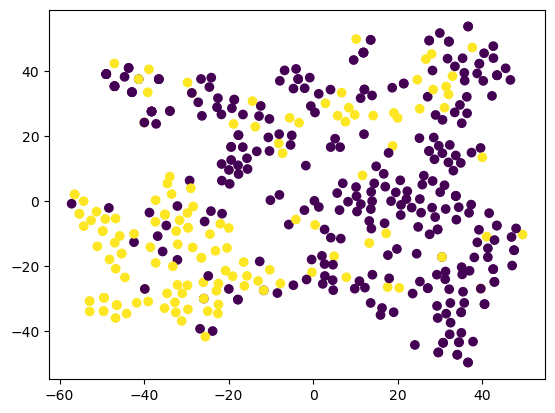

100%|██████████| 89/89 [00:00<00:00, 83923.80it/s]


Acthely_factors


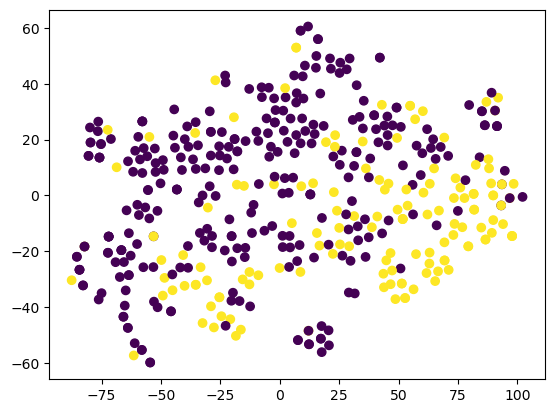

100%|██████████| 89/89 [00:00<00:00, 41048.28it/s]


PAM250


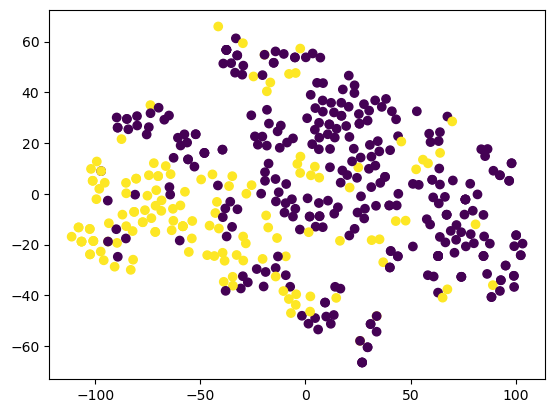

100%|██████████| 89/89 [00:00<00:00, 41518.52it/s]


BLOSUM62


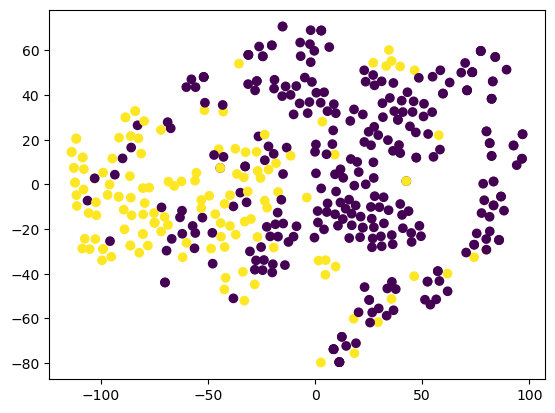

100%|██████████| 89/89 [00:00<00:00, 44476.71it/s]


Miyazawa_energies


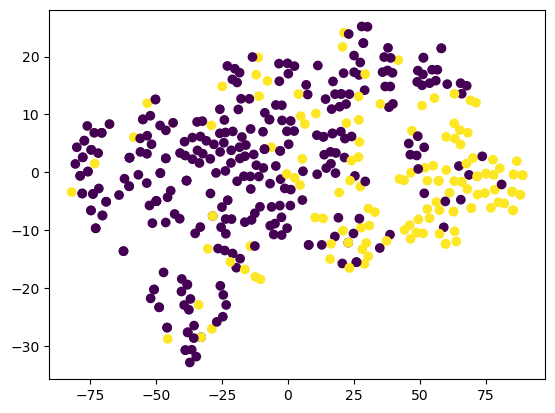

100%|██████████| 89/89 [00:00<00:00, 69696.24it/s]


Micheletti_potentials


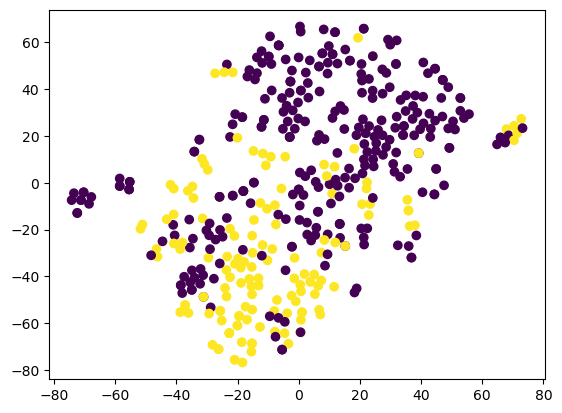

100%|██████████| 89/89 [00:00<00:00, 56662.58it/s]


AESNN3


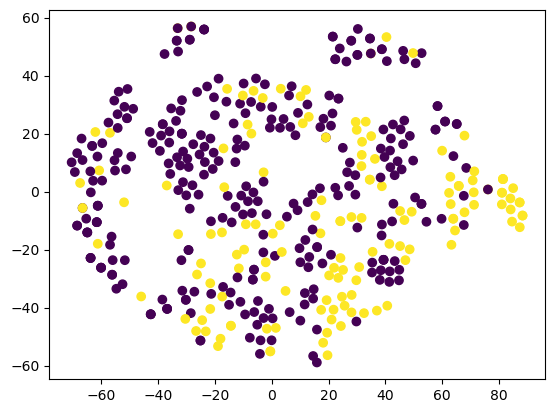

100%|██████████| 89/89 [00:00<00:00, 54944.52it/s]


ANN4D


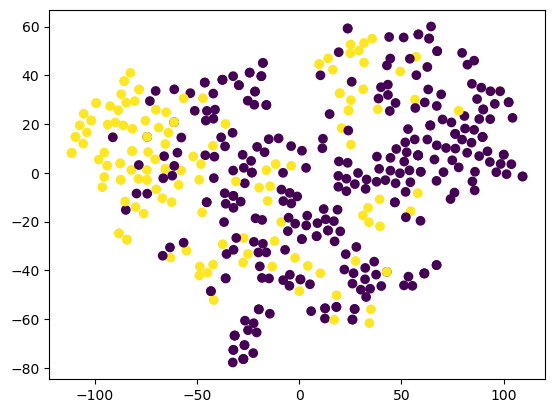

In [12]:
def mean(encodings):
    x = []
    for i in range(len(encodings)):
        x.append(list(encodings[i].values())[0])
    return np.array(x).mean(axis=0)

Data=[]
#encoding_type,encodings_train, encodings_test, y_train, y_test
encoding_types1 = [
        'One_hot', 'One_hot_6_bit', 'Binary_5_bit', 'Hydrophobicity_matrix', 
        'Meiler_parameters', 'Acthely_factors', 'PAM250', 'BLOSUM62', 'Miyazawa_energies', 
        'Micheletti_potentials', 'AESNN3', 'ANN4D', 'ProtVec'
    ]
for encoding_type in encoding_types1:
    with open("./SequenceEncoding/data/%s.json" % encoding_type, 'r') as load_f:
        encoding = json.load(load_f)
    class SequenceEncoding:
        encoding_types = [
            'One_hot', 'One_hot_6_bit', 'Binary_5_bit', 'Hydrophobicity_matrix', 
            'Meiler_parameters', 'Acthely_factors', 'PAM250', 'BLOSUM62', 'Miyazawa_energies', 
            'Micheletti_potentials', 'AESNN3', 'ANN4D'
        ]
        residue_types = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','X']

        def __init__(self, encoding_type="One_hot"):
            if encoding_type not in SequenceEncoding.encoding_types:
                raise Exception("Encoding type \'%s\' not found" % encoding_type)
            self.encoding_type = encoding_type

        def get_ProtVec_encoding(self, ProtVec, seq, overlap=True):
            if overlap:
                encodings = []
                for i in range(len(seq)-2):
                    encodings.append({seq[i:i+3]: ProtVec[seq[i:i+3]]}) if ProtVec.__contains__(seq[i:i+3]) else encodings.append({seq[i:i+3]: ProtVec["<unk>"]})
            else:
                encodings_1, encodings_2, encodings_3 = [], [], []
                for i in range(0, len(seq), 3):
                    if i+3 <= len(seq):
                        encodings_1.append({seq[i:i+3]: ProtVec[seq[i:i+3]]}) if ProtVec.__contains__(seq[i:i+3]) else encodings_1.append({seq[i:i+3]: ProtVec["<unk>"]})
                    if i+4 <= len(seq):
                        encodings_2.append({seq[i+1:i+4]: ProtVec[seq[i+1:i+4]]}) if ProtVec.__contains__(seq[i+1:i+4]) else encodings_2.append({seq[i+1:i+4]: ProtVec["<unk>"]})
                    if i+5 <= len(seq):
                        encodings_3.append({seq[i+2:i+5]: ProtVec[seq[i+2:i+5]]}) if ProtVec.__contains__(seq[i+2:i+5]) else encodings_3.append({seq[i+2:i+5]: ProtVec["<unk>"]})
                encodings = [encodings_1, encodings_2, encodings_3]
            return encodings

        def get_encoding(self, seq, overlap=True):
            seq = seq.upper()
            encoding_data = []
            if self.encoding_type == "ProtVec":            
                encoding_data = self.get_ProtVec_encoding(encoding, seq, overlap)
            else:
                for res in seq:
                    if res not in SequenceEncoding.residue_types:
                        res = "X"
                    encoding_data.append({res: encoding[res]})
            return encoding_data
    
    try:
        seqEncoding = SequenceEncoding(encoding_type)
    except:
        continue

    # train
    overall = map(seqEncoding.get_encoding, tqdm(x_train.tolist()))
    overall = list(overall)
    overall_2 = map(mean, tqdm(overall))
    overall_2 = list(overall_2)
    for i in range(len(overall_2)):
        try:
            overall_2[i] = list(overall_2[i])
        except:
            continue
    encodings_train = overall_2
    overall = map(seqEncoding.get_encoding, tqdm(x_test.tolist()))
    overall = list(overall)
    overall_2 = map(mean, tqdm(overall))
    overall_2 = list(overall_2)
    #make into 2d matrix
    for i in range(len(overall_2)):
        try:
            overall_2[i] = list(overall_2[i])
        except:
            continue
    encodings_test = overall_2
    
    #convert to 2d numpy array
    encodings_train = np.array(encodings_train)
    encodings_test = np.array(encodings_test)
    #viusalise the data with tsne
    print(encoding_type)

    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    tsne = TSNE(n_components=2, random_state=0)
    #combine test and train for visualisation
    encodings = np.concatenate((encodings_train, encodings_test))
    y = np.concatenate((y_train, y_test))
    tsne_encodings = tsne.fit_transform(encodings)
    plt.scatter(tsne_encodings[:,0], tsne_encodings[:,1], c=y)
    plt.show()
    # tsne_encodings_train = tsne.fit_transform(encodings_train)
    # tsne_encodings_test = tsne.fit_transform(encodings_test)
    # plt.scatter(tsne_encodings_train[:,0], tsne_encodings_train[:,1], c=y_train)
    # plt.show()
    # plt.scatter(tsne_encodings_test[:,0], tsne_encodings_test[:,1], c=y_test)
    # plt.show()
    # #random forest classifier
    Data.append([encoding_type,encodings_train, encodings_test, y_train, y_test])
    # except:
    #     print('error')
    #     continue




In [15]:
for data in Data:
    encoding_type,encodings_train, encodings_test, y_train, y_test = data
    #print dimension of encoding and type
    print(encoding_type)
    print(encodings_train.shape)
    print(encodings_test.shape)


One_hot
(353, 21)
(89, 21)
One_hot_6_bit
(353, 6)
(89, 6)
Binary_5_bit
(353, 5)
(89, 5)
Hydrophobicity_matrix
(353, 20)
(89, 20)
Meiler_parameters
(353, 7)
(89, 7)
Acthely_factors
(353, 5)
(89, 5)
PAM250
(353, 20)
(89, 20)
BLOSUM62
(353, 20)
(89, 20)
Miyazawa_energies
(353, 20)
(89, 20)
Micheletti_potentials
(353, 20)
(89, 20)
AESNN3
(353, 3)
(89, 3)
ANN4D
(353, 4)
(89, 4)


In [6]:
#run logistic regression for all
from sklearn.linear_model import LogisticRegression
#random forest, decision trees, lightgbm, svm,knn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
#auc roc
from sklearn.metrics import roc_auc_score
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from imblearn import over_sampling

for data in Data:
    #create a file to store the results
    os.chdir('/home/pavit21178/btp/fourth meeting')
    encoding_type,encodings_train, encodings_test, y_train, y_test=data
    os.makedirs(f'results{encoding_type}', exist_ok=True)
    os.chdir(f'results{encoding_type}')
    #visualise the classes to see data distribution
    print(encoding_type)
    print(encodings_train.shape)
    #run logistic regression
    #randomly oversample the train data

    oversample = over_sampling.RandomOverSampler(sampling_strategy='minority')
    encodings_train, y_train = oversample.fit_resample(encodings_train, y_train)

    models = [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), LGBMClassifier(), SVC(), KNeighborsClassifier()]
    model_names = ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'LGBMClassifier', 'SVC', 'KNeighborsClassifier']

    for model, model_name in zip(models, model_names):
        print('hi')
        #store in a file
        with open(f'{model_name}.txt', 'w') as f:
            model.fit(encodings_train, y_train)
            y_pred = model.predict(encodings_test)
            f.write(f'Classification Report: {classification_report(y_test, y_pred)}')
            f.write(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}\n')
            f.write(f'F1 Score: {f1_score(y_test, y_pred)}\n')
            f.write(f'Precision Score: {precision_score(y_test, y_pred)}\n')
            f.write(f'Mathews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred)}\n')
            f.write(f'Accuracy Score: {accuracy_score(y_test, y_pred)}\n')
            f.write(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}\n')
            print(model_name)
            #hyperparameter tuning
            if(model_name=="RandomForestClassifier"):
                print("bla")
                from sklearn.model_selection import RandomizedSearchCV
                param_dist = {
                    'n_estimators': [100, 200, 300, 400, 500],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'bootstrap': [True, False]
                }
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_jobs=-1, verbose=2)
                grid_search.fit(encodings_train, y_train)
                f.write(f'Hyperparameter Tuning Results\n')
                f.write(f'Best Parameters: {grid_search.best_params_}\n')
                f.write(f'Best Score: {grid_search.best_score_}\n')
                y_pred = grid_search.best_estimator_.predict(encodings_test)
                f.write(f'Classification Report: {classification_report(y_test, y_pred)}')
                f.write(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}\n')
                f.write(f'F1 Score: {f1_score(y_test, y_pred)}\n')
                f.write(f'Precision Score: {precision_score(y_test, y_pred)}\n')
                f.write(f'Mathews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred)}\n')
                f.write(f'Accuracy Score: {accuracy_score(y_test, y_pred)}\n')
                f.write(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}\n')
            elif(model_name=="DecisionTreeClassifier"):
                from sklearn.model_selection import RandomizedSearchCV
                param_distributions = {
                    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['auto', 'sqrt', 'log2']
                }
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=3, n_jobs=-1, verbose=2)
                grid_search.fit(encodings_train, y_train)
                f.write(f'Hyperparameter Tuning Results\n')
                f.write(f'Best Parameters: {grid_search.best_params_}\n')
                f.write(f'Best Score: {grid_search.best_score_}\n')
                y_pred = grid_search.best_estimator_.predict(encodings_test)
                f.write(f'Classification Report: {classification_report(y_test, y_pred)}')
                f.write(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}\n')
                f.write(f'F1 Score: {f1_score(y_test, y_pred)}\n')
                f.write(f'Precision Score: {precision_score(y_test, y_pred)}\n')
                f.write(f'Mathews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred)}\n')
                f.write(f'Accuracy Score: {accuracy_score(y_test, y_pred)}\n')
                f.write(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}\n')
            
            elif(model_name=="LGBMClassifier"):
                continue
            
            elif(model_name=="SVC"):
                from sklearn.model_selection import RandomizedSearchCV
                param_distributions = {
                    'C': [0.1, 1, 10, 100, 1000],
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
                }
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=3, n_jobs=-1, verbose=2)
                grid_search.fit(encodings_train, y_train)
                f.write(f'Hyperparameter Tuning Results\n')
                f.write(f'Best Parameters: {grid_search.best_params_}\n')
                f.write(f'Best Score: {grid_search.best_score_}\n')
                y_pred = grid_search.best_estimator_.predict(encodings_test)
                f.write(f'Classification Report: {classification_report(y_test, y_pred)}')
                f.write(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}\n')
                f.write(f'F1 Score: {f1_score(y_test, y_pred)}\n')
                f.write(f'Precision Score: {precision_score(y_test, y_pred)}\n')
                f.write(f'Mathews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred)}\n')
                f.write(f'Accuracy Score: {accuracy_score(y_test, y_pred)}\n')
                f.write(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}\n')
            
            elif(model_name=="KNeighborsClassifier"):
                from sklearn.model_selection import RandomizedSearchCV
                param_distributions = {
                    'n_neighbors': [5, 10, 15, 20, 25],
                    'weights': ['uniform', 'distance'],
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size': [10, 20, 30, 40, 50],
                    'p': [1, 2]
                }
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=3, n_jobs=-1, verbose=2)
                grid_search.fit(encodings_train, y_train)
                f.write(f'Hyperparameter Tuning Results\n')
                f.write(f'Best Parameters: {grid_search.best_params_}\n')
                f.write(f'Best Score: {grid_search.best_score_}\n')
                y_pred = grid_search.best_estimator_.predict(encodings_test)
                f.write(f'Classification Report: {classification_report(y_test, y_pred)}')
                f.write(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}\n')
                f.write(f'F1 Score: {f1_score(y_test, y_pred)}\n')
                f.write(f'Precision Score: {precision_score(y_test, y_pred)}\n')
                f.write(f'Mathews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred)}\n')
                f.write(f'Accuracy Score: {accuracy_score(y_test, y_pred)}\n')
                f.write(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}\n')
            
            elif(model_name=="LogisticRegression"):
                from sklearn.model_selection import RandomizedSearchCV
                param_distributions = {
                    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                    'C': [0.1, 1, 10, 100, 1000],
                    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    'max_iter': [100, 200, 300, 400, 500]
                }
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=3, n_jobs=-1, verbose=2)
                grid_search.fit(encodings_train, y_train)
                f.write(f'Hyperparameter Tuning Results\n')
                f.write(f'Best Parameters: {grid_search.best_params_}\n')
                f.write(f'Best Score: {grid_search.best_score_}\n')
                y_pred = grid_search.best_estimator_.predict(encodings_test)
                f.write(f'Classification Report: {classification_report(y_test, y_pred)}')
                f.write(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}\n')
                f.write(f'F1 Score: {f1_score(y_test, y_pred)}\n')
                f.write(f'Precision Score: {precision_score(y_test, y_pred)}\n')
                f.write(f'Mathews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred)}\n')
                f.write(f'Accuracy Score: {accuracy_score(y_test, y_pred)}\n')
                f.write(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}\n')
            
            else:
                print('not done')
                continue
        print(f'{model_name} done')


